In [1]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd

In [2]:
output_dir = './opt_out'
epw_file = '../weather/Torre_Pellice-hour.epw'
# Define the list of idf files with different glazing type setting and set each type to a int flag
idf_files = ['../IDF/single_Hourly.idf','../IDF/double_Hourly.idf','../IDF/triple_Hourly.idf']
idf_flags = [1,2,3]
# idf_files = ['../IDF/single_Hourly.idf']
# idf_flags = [1]
per_sample_num = 30

In [3]:
# Load idf files defined in the list
buildings = []
for file in idf_files:
    buildings.append(ef.get_building(file))

In [4]:
# [materials.Name for materials in building.idfobjects['WindowShadingControl']]# get a list of the Name property of all IDF objects of class MATERIAL
# for materials in building.idfobjects["WindowShadingControl"]:
#     if materials.Name =='1001-MainXground:Zone1':
#         print(materials)

In [5]:
# Define the fields to optimaize
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795',\
                           field_name='Thickness')
ach = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',\
                            object_name='*',\
                            field_name='Air Changes per Hour')
shading_temp = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint')
shading_irradiation = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint 2')

In [6]:
# Define the values for each field
insulation_range = CategoryParameter(options=[0.01,0.10,0.20,0.30,0.40])
ach_choice = CategoryParameter(options=[0,2,4,6])
shading_temp_range=CategoryParameter(options=[18,20,22,24,26,28])
shading_irradiation_range=CategoryParameter(options=[80,160,240,320])

In [7]:
# Define the params according to fields and field valuse
insulation_param = Parameter(selector=insulation,
                            value_descriptors=[insulation_range],
                            name='Insulation Thickness')
ach_param = Parameter(selector=ach,
                            value_descriptors=[ach_choice],
                            name='ACH')
shading_temp_param = Parameter(selector=shading_temp,
                            value_descriptors=[shading_temp_range],
                            name='shading temperature')
shading_irradiation_param =Parameter(selector=shading_irradiation,
                            value_descriptors=[shading_irradiation_range],
                            name='shading irradiation')

parameters = [insulation_param,ach_param,shading_temp_param,shading_irradiation_param] 

In [8]:
# Define the objectives and the problem
objectives = ['Electricity:Facility','DistrictHeating:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
problem

EPProblem(inputs=[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[CategoryParameter(options=[0.01, 0.1, 0.2, 0.3, 0.4])]), Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[CategoryParameter(options=[0, 2, 4, 6])]), Parameter(selector=FieldSelector(field_name='Setpoint', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[18, 20, 22, 24, 26, 28])]), Parameter(selector=FieldSelector(field_name='Setpoint 2', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[80, 160, 240, 320])])], outputs=[MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f50f5b69550>, key_name='Electricity:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f50f5b69

In [9]:
# Create the samples (each idf with different glazing setting will run accross these samples)
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=per_sample_num)
samples

,Insulation Thickness,ACH,shading temperature,shading irradiation
0,0.01,6,22,240
1,0.30,0,20,160
2,0.20,2,28,80
3,0.01,6,20,80
4,0.01,6,26,320
5,0.01,6,26,240
6,0.10,4,22,80
7,0.30,4,28,320
8,0.40,4,24,320
9,0.10,4,20,320


In [10]:
# Evaluate the probem with different idfs and collect the results
results = []
for i in range(len(buildings)):
    evaluator = EvaluatorEP(problem, buildings[i], out_dir=output_dir, err_dir=output_dir ,epw=epw_file) # evaluator = problem + building
    output = evaluator.df_apply(samples, keep_input=True)
    results.append(output)

Executing:   0%|          | 0/30 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 15.88sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Var

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/30 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/30 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorpti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing 

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 00:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "UNINSULATED WALL 30CM", Construction # 23
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone Report Variables
Initializing Surface (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade

EnergyPlus Completed Successfully.


In [25]:
dataframes = []
for i in range(len(results)):
    df = results[i]
    df['glazing layers']=idf_flags[i]
    dataframes.append(df)
#     final_result.append(df,ignore_index=True)
merged_result = pd.concat(dataframes,ignore_index=True)
electricity = merged_result["Electricity:Facility"]
electricity = electricity/3.6e6
merged_result["Electricity:Facility"]=electricity
heating = merged_result["DistrictHeating:Facility"]
heating = heating/3.6e6
merged_result["DistrictHeating:Facility"]=heating
merged_result=merged_result.reindex(columns=["Insulation Thickness","ACH","shading temperature","shading irradiation","glazing layers","Electricity:Facility","DistrictHeating:Facility"])

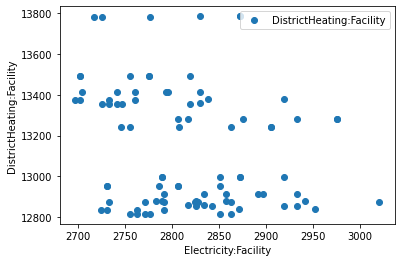

In [26]:
_ = merged_result.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.savefig(output_dir+'/obj_vs.png')

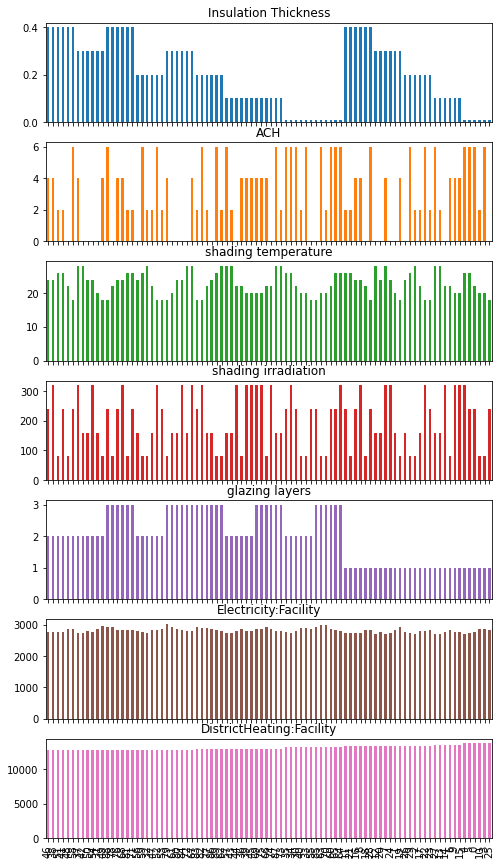

In [27]:
outputs = merged_result.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))
outputs.to_csv(output_dir + '/result' + '.csv', index = False)
plt.savefig(output_dir+'/sort_value.png')

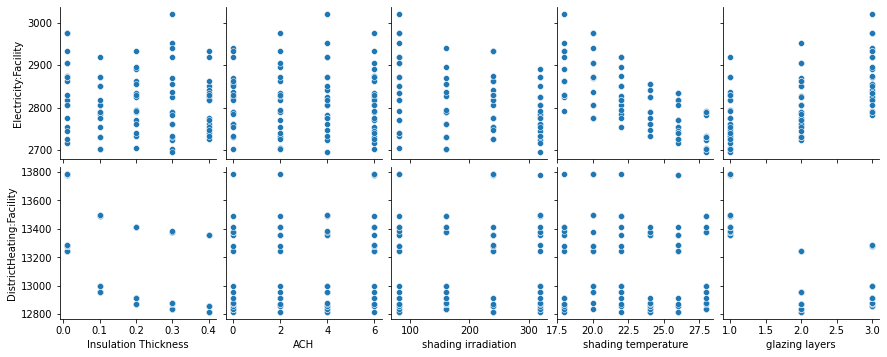

In [28]:
var= list(set(merged_result.columns.tolist())-set(objectives))
_=pairplot(outputs,x_vars=var, y_vars=objectives, kind="scatter")
plt.savefig(output_dir+'/parametric_analysis.png')

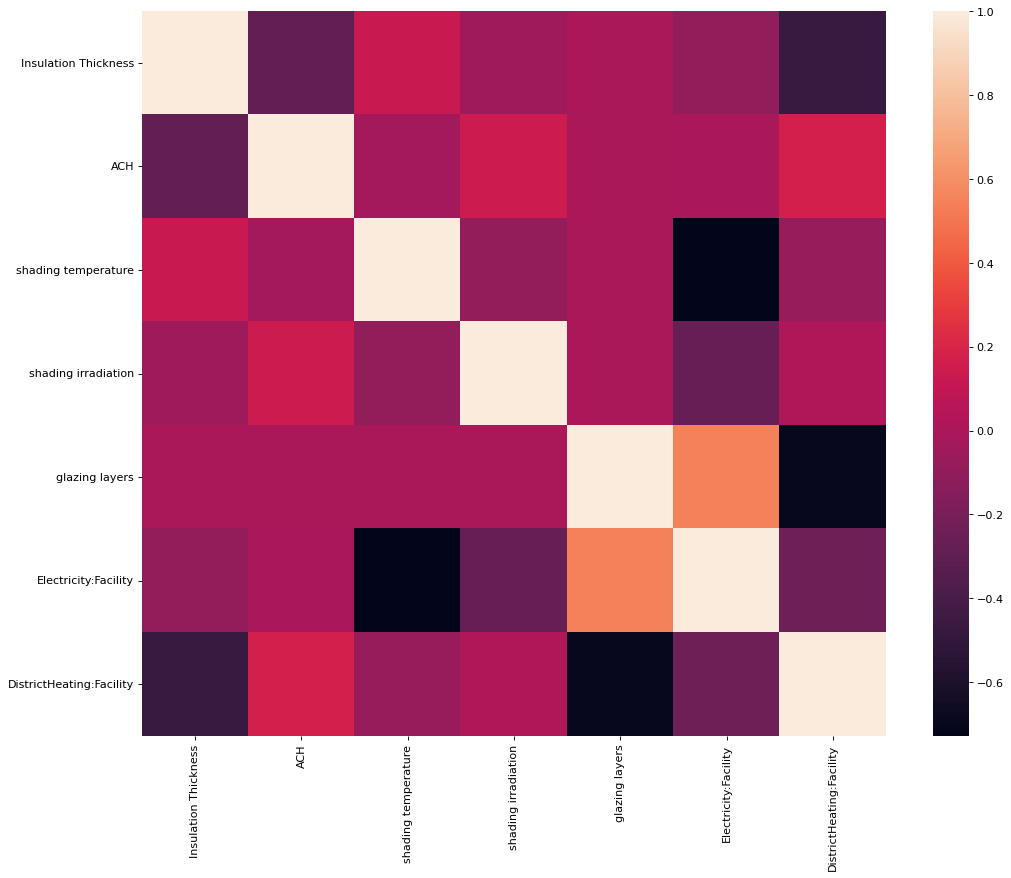

In [29]:
plt.figure(figsize=(15, 12), dpi=80)
_= heatmap(outputs.corr())
plt.savefig(output_dir+'/heatmap_sam.png')